# <font color='lightgreen'>ARIMA Time Series analysis - manual fit of models</font>

#Imports & Functions

In [ ]:
import pandas as pd
import numpy as np
import math
#connect to drive
from google.colab import drive
# visualisation
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.graph_objects as go
import ipywidgets as widgets
import matplotlib.pyplot as plt
#Dickey-Fuller Test
from statsmodels.tsa.stattools import adfuller
#pacf and acf
import statsmodels.graphics.tsaplots as sgt
# ARMA model
from statsmodels.tsa.arima.model import ARIMA
#RMSE
from sklearn.metrics import mean_squared_error
from math import sqrt
# combinations
import itertools

In [ ]:
def dicky_fuller_test_for_stationary(x,name):
# Null Hypothesis (H0): If failed to be rejected, it suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.
# Alternate Hypothesis(H1): The null hypothesis is rejected; it suggests the time series does not have a unit root, meaning it is stationary. It does not have time-dependent structure.
  result_b= adfuller(x)
  print('Dicky test for ',name,':')
  print('ADF Statistic: %f' % result_b[0])
  print('p-value: %f' % result_b[1])
  print("if the statistic < critical value, reject Ho, else accept H0")
  print('Critical Values:')
  for key, value in result_b[4].items():
    print('\t%s: %.3f' % (key, value))
    #print("if ",result_b[0]," < ",result_b[4][key]," then reject Ho ","if ",result_b[0]," >= ",result_b[4][key], "accept Ho")
    if result_b[0] < result_b[4][key]:
      print("Result: Reject Ho - Time Series is Stationary")
    else:
      print("Failed to Reject Ho - Time Series is Non-Stationary")

In [ ]:
# autoregressive models: AR(p)
# moving average models: MA(q)
# mixed autoregressive moving average models: ARMA(p, q)
# integration models: ARIMA(p, d, q)

def create_model_ARMA(x,p,q,print_results=True):
  model_ret_ar_1 = ARIMA(x, order=(p,0,q))
  results_ret_ar_1 = model_ret_ar_1.fit()
  if print_results:
    print(model_ret_ar_1.fit().llf)
    print(results_ret_ar_1.summary())
  return results_ret_ar_1

In [ ]:
def predict_ARMA_model(train,test,chosen_p,chosen_q,print_coef_results=False):# train and test are pandas seires
  dict_models=dict()
  model_fit=create_model_ARMA(train,chosen_p,chosen_q,print_coef_results)
  predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
  rmse = sqrt(mean_squared_error(test, predictions))
  print('\n RMSE for time series with p='+str(chosen_p)+' and q='+str(chosen_q)+' :' + str(round(rmse,2)))
  return rmse,model_fit

In [ ]:
def choose_best_model_ARMA(train,test,p_list,q_list):# train and test are pandas seires
  p_q_list=[p_list,q_list]
  combination_list = [p for p in itertools.product(*p_q_list)]
  for item in combination_list:
    p=item[0]
    q=item[1]
    if combination_list.index(item)==0:
      chosen_p=p
      chosen_q=q
      best_rmse,best_model_fit=predict_ARMA_model(train,test,p,q)
    else:
      current_rmse,current_model_fit=predict_ARMA_model(train,test,p,q)
      if current_rmse<best_rmse:
        chosen_p=p
        chosen_q=q
        best_rmse=current_rmse
        best_model_fit=current_model_fit
  print('\n Best RMSE for time series is with p='+str(chosen_p)+' and q='+str(chosen_q)+', with score :' + str(round(best_rmse,2)))
  return best_model_fit

# Ex 1

## 1) Load data and select 3 districts

In [ ]:
drive.mount('/content/drive')
path = "/content/drive/MyDrive/time series/home ex/hungary_chickenpox.csv"
df_raw = pd.read_csv(path)
print("Shape: ",df_raw.shape)
df_raw.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Shape:  (522, 21)


,Date,BUDAPEST,BARANYA,BACS,BEKES,BORSOD,CSONGRAD,FEJER,GYOR,HAJDU,...,JASZ,KOMAROM,NOGRAD,PEST,SOMOGY,SZABOLCS,TOLNA,VAS,VESZPREM,ZALA
0,3/1/2005,168,79,30,173,169,42,136,120,162,...,130,57,2,178,66,64,11,29,87,68
1,10/1/2005,157,60,30,92,200,53,51,70,84,...,80,50,29,141,48,29,58,53,68,26
2,17/01/2005,96,44,31,86,93,30,93,84,191,...,64,46,4,157,33,33,24,18,62,44
3,24/01/2005,163,49,43,126,46,39,52,114,107,...,63,54,14,107,66,50,25,21,43,31
4,31/01/2005,122,78,53,87,103,34,95,131,172,...,61,49,11,124,63,56,7,47,85,60


In [ ]:
df_raw.isna().sum() # checking for nulls before selecting districs

Date        0
BUDAPEST    0
BARANYA     0
BACS        0
BEKES       0
BORSOD      0
CSONGRAD    0
FEJER       0
GYOR        0
HAJDU       0
HEVES       0
JASZ        0
KOMAROM     0
NOGRAD      0
PEST        0
SOMOGY      0
SZABOLCS    0
TOLNA       0
VAS         0
VESZPREM    0
ZALA        0
dtype: int64

In [ ]:
df=df_raw[['Date','BUDAPEST','ZALA','FEJER']] # selection 3 districs
df.head()

,Date,BUDAPEST,ZALA,FEJER
0,3/1/2005,168,68,136
1,10/1/2005,157,26,51
2,17/01/2005,96,44,93
3,24/01/2005,163,31,52
4,31/01/2005,122,60,95


## 2) Plot the series

In [ ]:
#using plotly instead of matplotlib for better visualisation
fig = make_subplots(rows=3, cols=1)

fig.append_trace(go.Scatter(x=df['Date'], y=df['BUDAPEST'],name='BUDAPEST'),
                row=1, col=1)

fig.append_trace(go.Scatter(x=df['Date'],y=df['ZALA'],name='ZALA'),
                row=2, col=1)

fig.append_trace(go.Scatter(x=df['Date'], y=df['FEJER'],name='FEJER'),
                row=3, col=1)

fig.update_yaxes(title_text="chickenpox in Budapest", row=1, col=1)
fig.update_yaxes(title_text="chickenpox in Zala", row=2, col=1)
fig.update_yaxes(title_text="chickenpox in Fejer", row=3, col=1)
fig.update_xaxes(title_text="Date", row=3, col=1)


fig.update_layout(height=1000, width=2000, title_text="Hungary chickenpox 2005-2015 - Budapest, Zala, Fejer")
fig.show()

# 3) Fuller Dicky test

In [ ]:
dicky_fuller_test_for_stationary(df['BUDAPEST'],'Budapest')
print('\n')
dicky_fuller_test_for_stationary(df['ZALA'],'Zala')
print('\n')
dicky_fuller_test_for_stationary(df['FEJER'],'Fejer')

Dicky test for  Budapest :
ADF Statistic: -6.933218
p-value: 0.000000
if the statistic < critical value, reject Ho, else accept H0
Critical Values:
	1%: -3.443
Result: Reject Ho - Time Series is Stationary
	5%: -2.867
Result: Reject Ho - Time Series is Stationary
	10%: -2.570
Result: Reject Ho - Time Series is Stationary


Dicky test for  Zala :
ADF Statistic: -4.981767
p-value: 0.000024
if the statistic < critical value, reject Ho, else accept H0
Critical Values:
	1%: -3.443
Result: Reject Ho - Time Series is Stationary
	5%: -2.867
Result: Reject Ho - Time Series is Stationary
	10%: -2.570
Result: Reject Ho - Time Series is Stationary


Dicky test for  Fejer :
ADF Statistic: -6.187222
p-value: 0.000000
if the statistic < critical value, reject Ho, else accept H0
Critical Values:
	1%: -3.443
Result: Reject Ho - Time Series is Stationary
	5%: -2.867
Result: Reject Ho - Time Series is Stationary
	10%: -2.570
Result: Reject Ho - Time Series is Stationary


# 4+5) ACF, PACF graphs and seasonality

ACF graph:
X axis is the number of lags, y axis is phi coefficient (coefficients of correlation between a time series).
The lag-1 value is the correlation coefficient between y(t) and y(t-1), lag-2 is the correlation coefficient between y(t) and y(t-2) and so on.
Blue area represent level of significance (95% confidence), points outside of the blue area are different than 0 significantly and imply autocorrelation

PACF graph:
For Budapest time series:
Same as ACF but patial, we consider only the direct correlation between seires t and t-k.
PACF can be explained using a linear regression where we predict y(t) from y(t-1), y(t-2), and y(t-3). In PACF, we correlate the “parts” of y(t) and y(t-3) that are not predicted by y(t-1) and y(t-2).

we can find if the seires' formula by the following thumb rules:


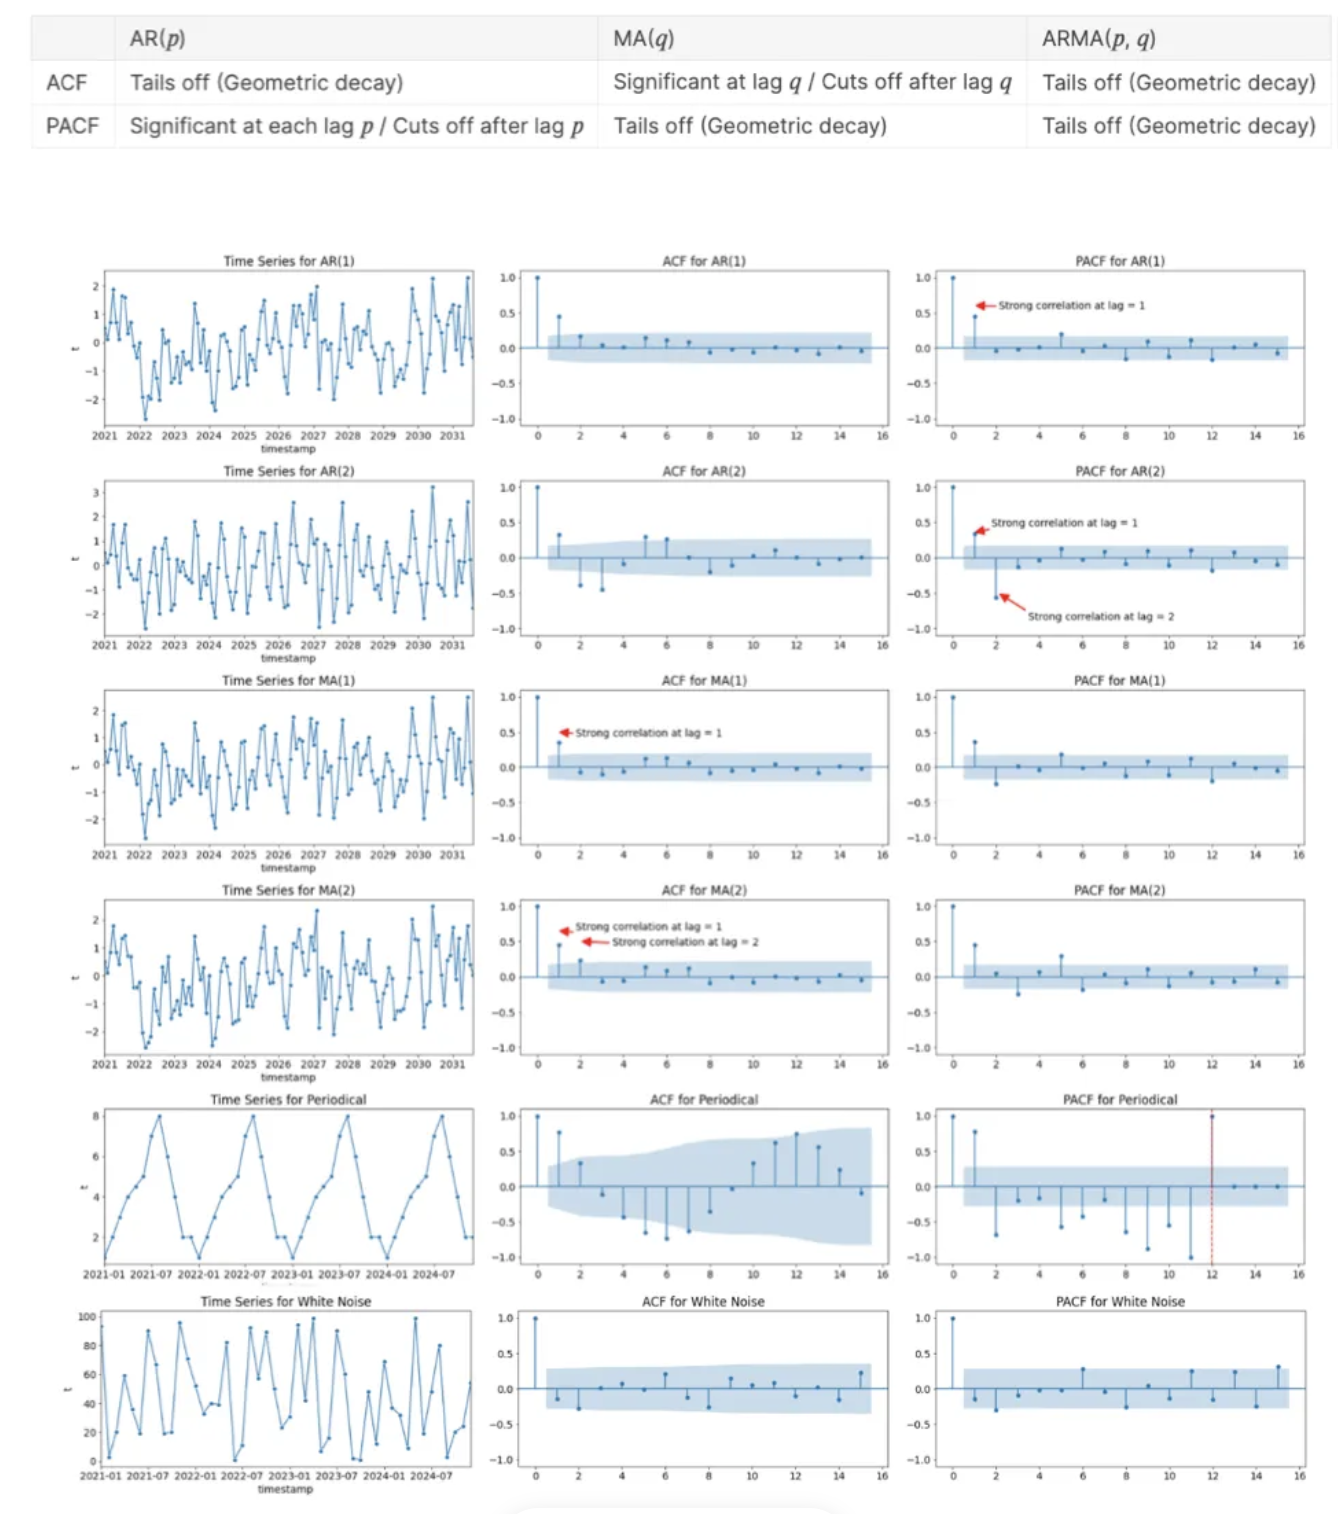

In [ ]:
list_of_time_series=['BUDAPEST','ZALA','FEJER']

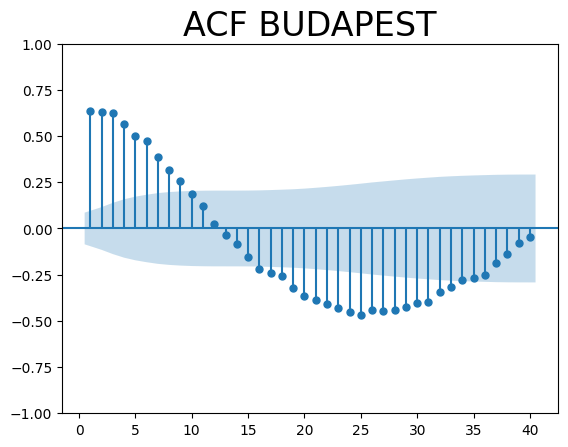

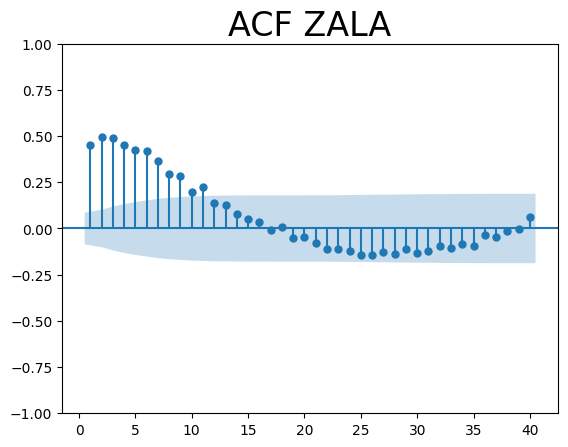

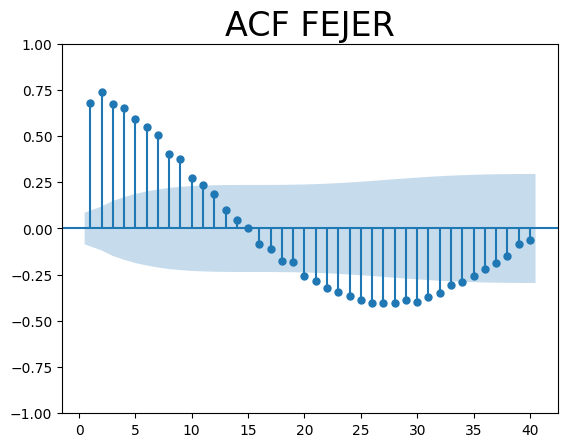

In [ ]:
for seires in list_of_time_series:
  sgt.plot_acf(df[seires], lags = 40, zero = False)
  plt.title("ACF "+seires, size = 24)
  plt.show()

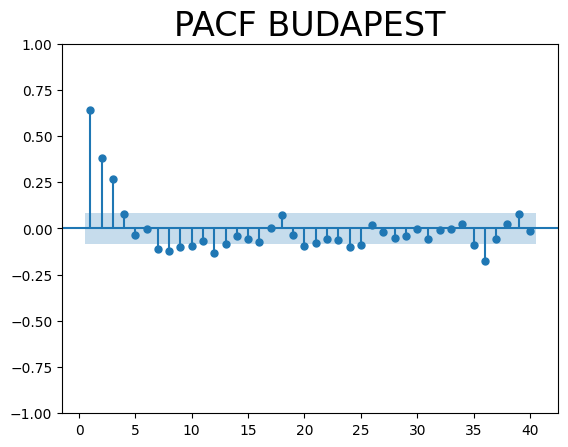

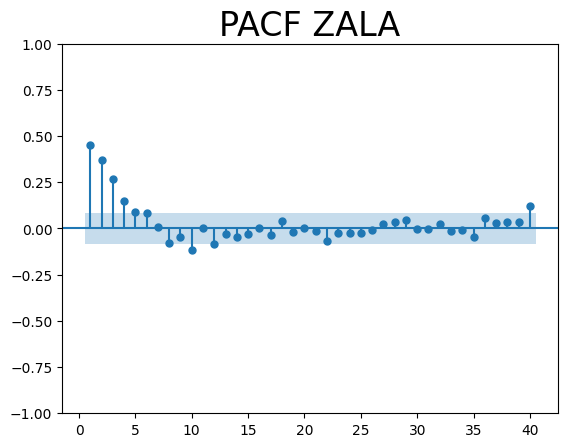

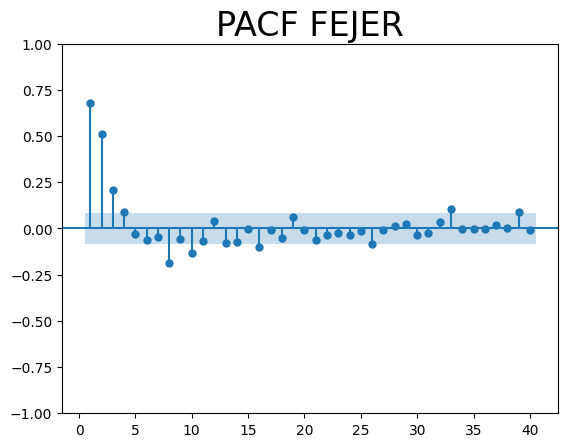

In [ ]:
for seires in list_of_time_series:
  sgt.plot_pacf(df[seires], lags = 40, zero = False, method = ('ols'))
  # In this instance, we will rely on the order of least squares (OLS)
  plt.title("PACF "+seires, size = 24)
  plt.show()

###  ACF & PACF summary

Budapest: We can see it's periodical, the points in ACF are out of the blue area in periodic shape as well as the PACF,

ZALA: Overall the series seems periodical, but we could also look at this as if ACF and PACF are in geometric decay with a bit of noise, we can fit ARMA(11,4)

FEJER: Simlarly to Budapest, we see it's periodical


Both Budapest and Fejer shows seasonality, we can see the correlated points at low lags, then we have no correlation for few lags then we see another batch of lags that are correlated and another batch afterwrds that is not. (we also got the same result in the Fuller Dicky test)

# 6+7) Autoregressive model - AR

In [ ]:
data=df.copy()
data.Date = pd.to_datetime(data['Date'], dayfirst = True)
df_train, df_test = data.iloc[:250], data.iloc[250:]
print("train shape: ",df_train.shape, ", test shape: ",df_test.shape)
df_train.head()

train shape:  (250, 4) , test shape:  (272, 4)


,Date,BUDAPEST,ZALA,FEJER
0,2005-01-03,168,68,136
1,2005-01-10,157,26,51
2,2005-01-17,96,44,93
3,2005-01-24,163,31,52
4,2005-01-31,122,60,95


In [ ]:
for i in range(1,8): #loop for manualy selecting optional p - checking all coefiecents are signficant (less than 0.05)
  print("p = ",i)
  create_model_ARMA(df_train['BUDAPEST'],i,0)

p =  1
-1379.038699072125
                               SARIMAX Results                                
Dep. Variable:               BUDAPEST   No. Observations:                  250
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -1379.039
Date:                Tue, 11 Apr 2023   AIC                           2764.077
Time:                        13:54:29   BIC                           2774.642
Sample:                             0   HQIC                          2768.329
                                - 250                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        107.0758     18.241      5.870      0.000      71.324     142.827
ar.L1          0.6835      0.041     16.539      0.000       0.602       0.764
sigma2      3611.5308    2

In [ ]:
for i in range(1,8): #loop for selecting p
  print("p = ",i)
  create_model_ARMA(df_train['ZALA'],i,0)

p =  1
-1054.7731768881258
                               SARIMAX Results                                
Dep. Variable:                   ZALA   No. Observations:                  250
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -1054.773
Date:                Tue, 11 Apr 2023   AIC                           2115.546
Time:                        13:54:32   BIC                           2126.111
Sample:                             0   HQIC                          2119.798
                                - 250                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         22.9249      4.191      5.470      0.000      14.711      31.139
ar.L1          0.6524      0.053     12.299      0.000       0.548       0.756
sigma2       269.9108    

In [ ]:
for i in range(1,8): #loop for selecting p
  print("p = ",i)
  create_model_ARMA(df_train['FEJER'],i,0)

p =  1
-1146.728022641251
                               SARIMAX Results                                
Dep. Variable:                  FEJER   No. Observations:                  250
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -1146.728
Date:                Tue, 11 Apr 2023   AIC                           2299.456
Time:                        13:54:36   BIC                           2310.020
Sample:                             0   HQIC                          2303.708
                                - 250                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         37.5304      9.437      3.977      0.000      19.034      56.027
ar.L1          0.7426      0.048     15.589      0.000       0.649       0.836
sigma2       562.6985     

In [ ]:
best_ar_b_model=choose_best_model_ARMA(df_train['BUDAPEST'],df_test['BUDAPEST'],list(range(1,4)),[0]) # list of optional q is only 0 since it's AR model not ARMA


 RMSE for time series with p=1 and q=0 :70.2

 RMSE for time series with p=2 and q=0 :69.82

 RMSE for time series with p=3 and q=0 :69.83

 Best RMSE for time series is with p=2 and q=0, with score :69.82


In [ ]:
best_ar_z_model=choose_best_model_ARMA(df_train['ZALA'],df_test['ZALA'],list(range(1,5)),[0]) # list of optional q is only 0 since it's AR model not ARMA


 RMSE for time series with p=1 and q=0 :22.72

 RMSE for time series with p=2 and q=0 :22.74

 RMSE for time series with p=3 and q=0 :22.72

 RMSE for time series with p=4 and q=0 :22.67

 Best RMSE for time series is with p=4 and q=0, with score :22.67


In [ ]:
best_ar_f_model=choose_best_model_ARMA(df_train['FEJER'],df_test['FEJER'],list(range(1,3)),[0]) # list of optional q is only 0 since it's AR model not ARMA


 RMSE for time series with p=1 and q=0 :28.26

 RMSE for time series with p=2 and q=0 :28.69

 Best RMSE for time series is with p=1 and q=0, with score :28.26


# 8) ARMA model

In [ ]:
range1=list(range(1,5))
range2=list(range(1,5))
list_num=[range1,range2]
combination = [p for p in itertools.product(*list_num)]
print(combination)

[(1, 1), (1, 2), (1, 3), (1, 4), (2, 1), (2, 2), (2, 3), (2, 4), (3, 1), (3, 2), (3, 3), (3, 4), (4, 1), (4, 2), (4, 3), (4, 4)]


In [ ]:
for item in combination: #loop for manualy selecting optional p and q- checking all coefiecents are signficant (less than 0.05)
  print("p = ",item[0],", q = ",item[1])
  create_model_ARMA(df_train['BUDAPEST'],item[0],item[1])

p =  1 , q =  1
-1354.026924559653
                               SARIMAX Results                                
Dep. Variable:               BUDAPEST   No. Observations:                  250
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -1354.027
Date:                Tue, 11 Apr 2023   AIC                           2716.054
Time:                        13:54:46   BIC                           2730.140
Sample:                             0   HQIC                          2721.723
                                - 250                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        107.0559     35.534      3.013      0.003      37.410     176.702
ar.L1          0.9333      0.033     28.056      0.000       0.868       0.998
ma.L1         -0.

/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



-1338.6176825015314
                               SARIMAX Results                                
Dep. Variable:               BUDAPEST   No. Observations:                  250
Model:                 ARIMA(2, 0, 3)   Log Likelihood               -1338.618
Date:                Tue, 11 Apr 2023   AIC                           2691.235
Time:                        13:54:50   BIC                           2715.886
Sample:                             0   HQIC                          2701.156
                                - 250                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        107.6150      6.659     16.161      0.000      94.563     120.667
ar.L1          1.9544      0.030     64.416      0.000       1.895       2.014
ar.L2         -0.9688      0.030

/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



-1338.5902116038565
                               SARIMAX Results                                
Dep. Variable:               BUDAPEST   No. Observations:                  250
Model:                 ARIMA(2, 0, 4)   Log Likelihood               -1338.590
Date:                Tue, 11 Apr 2023   AIC                           2693.180
Time:                        13:54:53   BIC                           2721.352
Sample:                             0   HQIC                          2704.519
                                - 250                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        107.6449      6.559     16.413      0.000      94.790     120.500
ar.L1          1.9513      0.033     58.668      0.000       1.886       2.016
ar.L2         -0.9656      0.033

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invert

-1338.6633736607755
                               SARIMAX Results                                
Dep. Variable:               BUDAPEST   No. Observations:                  250
Model:                 ARIMA(3, 0, 2)   Log Likelihood               -1338.663
Date:                Tue, 11 Apr 2023   AIC                           2691.327
Time:                        13:54:57   BIC                           2715.977
Sample:                             0   HQIC                          2701.248
                                - 250                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        107.7920      6.755     15.957      0.000      94.552     121.032
ar.L1          1.8223      0.092     19.730      0.000       1.641       2.003
ar.L2         -0.7108      0.166

/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



-1339.0421435026592
                               SARIMAX Results                                
Dep. Variable:               BUDAPEST   No. Observations:                  250
Model:                 ARIMA(3, 0, 3)   Log Likelihood               -1339.042
Date:                Tue, 11 Apr 2023   AIC                           2694.084
Time:                        13:54:59   BIC                           2722.256
Sample:                             0   HQIC                          2705.423
                                - 250                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        107.5333      7.007     15.347      0.000      93.800     121.267
ar.L1          0.9888      0.069     14.296      0.000       0.853       1.124
ar.L2          0.9255      0.130

/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



-1338.291421030916
                               SARIMAX Results                                
Dep. Variable:               BUDAPEST   No. Observations:                  250
Model:                 ARIMA(3, 0, 4)   Log Likelihood               -1338.291
Date:                Tue, 11 Apr 2023   AIC                           2694.583
Time:                        13:55:01   BIC                           2726.276
Sample:                             0   HQIC                          2707.338
                                - 250                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        107.9227      6.726     16.046      0.000      94.740     121.105
ar.L1          0.9804      0.087     11.308      0.000       0.810       1.150
ar.L2          0.9334      0.156 

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Lik

-1349.4048897195125
                               SARIMAX Results                                
Dep. Variable:               BUDAPEST   No. Observations:                  250
Model:                 ARIMA(4, 0, 3)   Log Likelihood               -1349.405
Date:                Tue, 11 Apr 2023   AIC                           2716.810
Time:                        13:55:05   BIC                           2748.503
Sample:                             0   HQIC                          2729.565
                                - 250                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        107.0312     33.563      3.189      0.001      41.250     172.813
ar.L1         -0.6986      0.137     -5.117      0.000      -0.966      -0.431
ar.L2          0.2100      0.125

/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



-1338.3580400479955
                               SARIMAX Results                                
Dep. Variable:               BUDAPEST   No. Observations:                  250
Model:                 ARIMA(4, 0, 4)   Log Likelihood               -1338.358
Date:                Tue, 11 Apr 2023   AIC                           2696.716
Time:                        13:55:08   BIC                           2731.931
Sample:                             0   HQIC                          2710.889
                                - 250                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        107.4623      6.907     15.557      0.000      93.924     121.001
ar.L1          0.9326      0.768      1.215      0.224      -0.572       2.437
ar.L2          0.9890      0.787

/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [ ]:
for item in combination: #loop for manualy selecting optional p and q- checking all coefiecents are signficant (less than 0.05)
  print("p = ",item[0],", q = ",item[1])
  create_model_ARMA(df_train['ZALA'],item[0],item[1])

p =  1 , q =  1
-1024.1337929624933
                               SARIMAX Results                                
Dep. Variable:                   ZALA   No. Observations:                  250
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -1024.134
Date:                Tue, 11 Apr 2023   AIC                           2056.268
Time:                        13:55:09   BIC                           2070.353
Sample:                             0   HQIC                          2061.937
                                - 250                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         23.1408      9.176      2.522      0.012       5.157      41.125
ar.L1          0.9539      0.027     35.630      0.000       0.901       1.006
ma.L1         -0

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



-1016.2305918773728
                               SARIMAX Results                                
Dep. Variable:                   ZALA   No. Observations:                  250
Model:                 ARIMA(2, 0, 4)   Log Likelihood               -1016.231
Date:                Tue, 11 Apr 2023   AIC                           2048.461
Time:                        13:55:15   BIC                           2076.633
Sample:                             0   HQIC                          2059.799
                                - 250                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         22.7328      7.256      3.133      0.002       8.511      36.955
ar.L1          1.3944      0.340      4.096      0.000       0.727       2.062
ar.L2         -0.4538      0.318

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



-1018.3502187402166
                               SARIMAX Results                                
Dep. Variable:                   ZALA   No. Observations:                  250
Model:                 ARIMA(3, 0, 4)   Log Likelihood               -1018.350
Date:                Tue, 11 Apr 2023   AIC                           2054.700
Time:                        13:55:18   BIC                           2086.394
Sample:                             0   HQIC                          2067.456
                                - 250                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         22.7373      8.666      2.624      0.009       5.751      39.723
ar.L1         -0.0614      0.258     -0.238      0.812      -0.567       0.445
ar.L2          0.5171      0.195

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Lik

-1016.3783940891128
                               SARIMAX Results                                
Dep. Variable:                   ZALA   No. Observations:                  250
Model:                 ARIMA(4, 0, 3)   Log Likelihood               -1016.378
Date:                Tue, 11 Apr 2023   AIC                           2050.757
Time:                        13:55:22   BIC                           2082.450
Sample:                             0   HQIC                          2063.512
                                - 250                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         22.8641      7.232      3.162      0.002       8.690      37.039
ar.L1          0.7483      3.277      0.228      0.819      -5.675       7.172
ar.L2          0.6769      5.353

/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



-1012.7086163804998
                               SARIMAX Results                                
Dep. Variable:                   ZALA   No. Observations:                  250
Model:                 ARIMA(4, 0, 4)   Log Likelihood               -1012.709
Date:                Tue, 11 Apr 2023   AIC                           2045.417
Time:                        13:55:27   BIC                           2080.632
Sample:                             0   HQIC                          2059.590
                                - 250                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         22.6635      5.121      4.425      0.000      12.626      32.701
ar.L1          0.0220      0.056      0.391      0.696      -0.088       0.132
ar.L2          1.7051      0.054

/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [ ]:
for item in combination: #loop for manualy selecting optional p and q- checking all coefiecents are signficant (less than 0.05)
  print("p = ",item[0],", q = ",item[1])
  create_model_ARMA(df_train['FEJER'],item[0],item[1])

p =  1 , q =  1
-1110.7073773003403
                               SARIMAX Results                                
Dep. Variable:                  FEJER   No. Observations:                  250
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -1110.707
Date:                Tue, 11 Apr 2023   AIC                           2229.415
Time:                        13:55:27   BIC                           2243.501
Sample:                             0   HQIC                          2235.084
                                - 250                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         39.3563     20.038      1.964      0.050       0.083      78.630
ar.L1          0.9616      0.023     42.429      0.000       0.917       1.006
ma.L1         -0

/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



-1095.6305720105952
                               SARIMAX Results                                
Dep. Variable:                  FEJER   No. Observations:                  250
Model:                 ARIMA(2, 0, 4)   Log Likelihood               -1095.631
Date:                Tue, 11 Apr 2023   AIC                           2207.261
Time:                        13:55:34   BIC                           2235.433
Sample:                             0   HQIC                          2218.599
                                - 250                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         36.9221      7.142      5.169      0.000      22.923      50.921
ar.L1          1.9433      0.034     57.896      0.000       1.877       2.009
ar.L2         -0.9548      0.031

/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



-1094.3277148311072
                               SARIMAX Results                                
Dep. Variable:                  FEJER   No. Observations:                  250
Model:                 ARIMA(3, 0, 3)   Log Likelihood               -1094.328
Date:                Tue, 11 Apr 2023   AIC                           2204.655
Time:                        13:55:37   BIC                           2232.827
Sample:                             0   HQIC                          2215.994
                                - 250                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         36.6126      7.181      5.099      0.000      22.539      50.686
ar.L1          1.2921      0.170      7.605      0.000       0.959       1.625
ar.L2          0.3102      0.319

/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



-1099.844030290833
                               SARIMAX Results                                
Dep. Variable:                  FEJER   No. Observations:                  250
Model:                 ARIMA(4, 0, 2)   Log Likelihood               -1099.844
Date:                Tue, 11 Apr 2023   AIC                           2215.688
Time:                        13:55:44   BIC                           2243.860
Sample:                             0   HQIC                          2227.026
                                - 250                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         36.8099     16.235      2.267      0.023       4.991      68.629
ar.L1          0.3638      0.053      6.804      0.000       0.259       0.469
ar.L2         -0.4157      0.062 

In [ ]:
best_arma_b_model=choose_best_model_ARMA(df_train['BUDAPEST'],df_test['BUDAPEST'],list(range(1,3)),list(range(1,3))) # list of optional q is only 0 since it's AR model not ARMA


 RMSE for time series with p=1 and q=1 :69.94

 RMSE for time series with p=1 and q=2 :69.86

 RMSE for time series with p=2 and q=1 :69.89

 RMSE for time series with p=2 and q=2 :64.74

 Best RMSE for time series is with p=2 and q=2, with score :64.74


In [ ]:
best_arma_z_model=choose_best_model_ARMA(df_train['ZALA'],df_test['ZALA'],list(range(1,3)),list(range(1,3))) # list of optional q is only 0 since it's AR model not ARMA


 RMSE for time series with p=1 and q=1 :22.75

 RMSE for time series with p=1 and q=2 :22.67

 RMSE for time series with p=2 and q=1 :22.67

 RMSE for time series with p=2 and q=2 :22.72

 Best RMSE for time series is with p=1 and q=2, with score :22.67


In [ ]:
best_arma_z_model=choose_best_model_ARMA(df_train['FEJER'],df_test['FEJER'],[1],list(range(1,3))) # list of optional q is only 0 since it's AR model not ARMA


 RMSE for time series with p=1 and q=1 :29.22

 RMSE for time series with p=1 and q=2 :28.99

 Best RMSE for time series is with p=1 and q=2, with score :28.99


# 9) Disscussion

**AR (autoregressive) Model:**

The time period at t is impacted by the observation at various slots t-1, t-2, t-3,..., t-k. The impact of previous time spots is decided by the coefficient factor at that particular period of time.
Yt = β₁* y-₁ + β₂* yₜ-₂ + β₃ * yₜ-₃ + ………… + βₖ * yₜ-ₖ


**MA (moving average) Model:**

The time period at t is impacted by the unexpected external factors at various slots t-1, t-2, t-3, ….., t-k. These unexpected impacts are known as Errors or Residuals. The impact of previous time spots is decided by the coefficient factor α at that particular period of time.
Yt = α₁* Ɛₜ-₁ + α₂ * Ɛₜ-₂ + α₃ * Ɛₜ-₃ + ………… + αₖ * Ɛₜ-ₖ


**ARMA model:**

This is a model that is combined from the AR and MA models. In this model, the impact of previous lags along with the residuals is considered for forecasting the future values of the time series. Here β represents the coefficients of the AR model and α represents the coefficients of the MA model.

Yt = β₁* yₜ-₁ + α₁* Ɛₜ-₁ + β₂* yₜ-₂ + α₂ * Ɛₜ-₂ + β₃ * yₜ-₃ + α₃ * Ɛₜ-₃ +………… + βₖ * yₜ-ₖ + αₖ * Ɛₜ-ₖ


---

In our case, best performing model for Budapest series was ARMA(2,2) with RMSE of 64.74 (lower only by 5.08 from the best AR model of (2) with score of 69.82)
best performing models for Zala series were AR(4),ARMA(1,2) with RMSE of 22.67 - no differance between the best performing models of AR and ARMA
best performing models for Fejer series was AR(1) with RMSE of 28.26 (lower only by 0.73 from the best ARMA model of (1,2) with score of 28.99)

Overall, the series that fits best to the models was Zala (which we also saw in the ACF and PACF graphs that it can fit better than the others that seemed more periodic).